# GCM Filters on POP tripolar grid

In [1]:
import gcm_filters
import numpy as np
import cupy as cp
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
list(gcm_filters.GridType)

[<GridType.CARTESIAN: 1>,
 <GridType.CARTESIAN_WITH_LAND: 2>,
 <GridType.POP_TRIPOLAR_GRID: 3>]

The centerpiece of this notebook is the newly added Laplacian on the `POP_TRIPOLAR_GRID`. The implementation of the `POP_TRIPOLAR_GRID` Laplacian lives on [this](https://github.com/NoraLoose/gcm-filters/tree/POP-simple-Laplacian) github branch. The `POP_TRIPOLAR_GRID` Laplacian is identical to the `CARTESIAN_WITH_LAND` Laplacian, but --in addition-- handles the exchanges across the POP tripolar boundary condition correctly (so far only for tracer fields). Note that both the `CARTESIAN_WITH_LAND` and the `POP_TRIPOLAR_GRID` Laplacians are adequate for filtering with **fixed coarsening factor** (rather than with fixed length scale), because this filter method operates on a uniform grid with dx=dy=1. 

This notebook has two main purposes:
* We will convince ourselves that the `POP_TRIPOLAR_GRID` Laplacian handles the tripolar boundary condition indeed correctly, by filtering a discrete delta function deployed close to the northern boundary.
* We will compare the timing of the `POP_TRIPOLAR_GRID` and the `CARTESIAN_WITH_LAND` Laplacians, to see how much performance we lose by dealing with the northern boundary exchanges. To put this performance loss into perspective, we will also compare to the `CARTESIAN` Laplacian: the latter is expected to be the fastest of all three, because it does not only ignore the northern boundary exchanges, but also continents.

### POP data

Open the POP 0.1 degree data that Ian saved.

In [3]:
ds = xr.open_dataset('/glade/work/igrooms/current_data', decode_times=False)

These are the important dimensions of our dataset:

In [4]:
Nt = np.size(ds.time)
Nz = np.size(ds.z_t)
Ny = np.size(ds.nlat)
Nx = np.size(ds.nlon)
print('Nt = %i, Nz = %i, Nx = %i, Ny = %i' %(Nt,Nz,Nx,Ny))

Nt = 1, Nz = 62, Nx = 3600, Ny = 2400


Note that the dataset has only one time slice, and we eventually want to compare the performance of our gcm-filters code with Ian's Fortran implementaion on bigger datasets.

In [5]:
wet_mask = xr.where(ds['KMT']>0,1,0)

Text(0.5, 1.0, 'wet_mask')

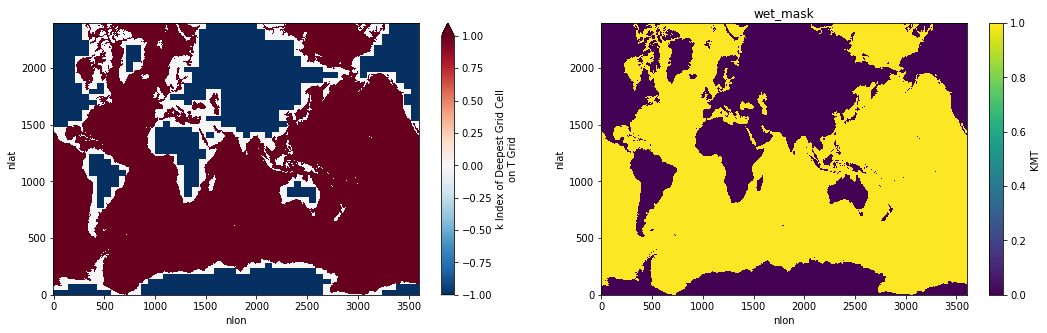

In [6]:
fig,axs = plt.subplots(1,2,figsize=(18,5))
ds.KMT.plot(ax=axs[0],vmin=ds.KMT.min())
wet_mask.plot(ax=axs[1])
axs[1].set_title('wet_mask')

### Creating the 3 filters to be compared

We create three filters of increasing complexity.

In [7]:
filter_cartesian = gcm_filters.Filter(
    filter_scale=10,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_steps=20,
    grid_type=gcm_filters.GridType.CARTESIAN,
    grid_vars={}
)
filter_cartesian

Filter(filter_scale=10, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=20, grid_type=<GridType.CARTESIAN: 1>)

In [8]:
filter_cartesian_with_land = gcm_filters.Filter(
    filter_scale=10,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_steps=20,
    grid_type=gcm_filters.GridType.CARTESIAN_WITH_LAND,
    grid_vars={'wet_mask': wet_mask}
)
filter_cartesian_with_land

Filter(filter_scale=10, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=20, grid_type=<GridType.CARTESIAN_WITH_LAND: 2>)

In [9]:
filter_pop_tripolar_grid = gcm_filters.Filter(
    filter_scale=10,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_steps=20,
    grid_type=gcm_filters.GridType.POP_TRIPOLAR_GRID,
    grid_vars={'wet_mask': wet_mask}
)
filter_pop_tripolar_grid

Filter(filter_scale=10, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=20, grid_type=<GridType.POP_TRIPOLAR_GRID: 3>)

## Testing the exchanges across the northern tripolar grid boundary

We define two discrete delta functions deployed close to the northern boundary. The first one gets assigned positive mass (=1), the second one gets assigned negative mass (=-1).

In [10]:
delta1 = 0 * xr.ones_like(ds.nlat*ds.nlon) 
delta1[2395,900] = 1
delta1 = delta1.where(wet_mask)

delta2 = 0 * xr.ones_like(ds.nlat*ds.nlon) 
delta2[2395,2500] = -1
delta2 = delta2.where(wet_mask)

In [11]:
delta1_filtered_cartesian_with_land = filter_cartesian_with_land.apply(delta1, dims=['nlat', 'nlon'])
delta2_filtered_cartesian_with_land = filter_cartesian_with_land.apply(delta2, dims=['nlat', 'nlon'])

delta1_filtered_pop_tripolar_grid = filter_pop_tripolar_grid.apply(delta1, dims=['nlat', 'nlon'])
delta2_filtered_pop_tripolar_grid = filter_pop_tripolar_grid.apply(delta2, dims=['nlat', 'nlon'])

/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  if __name__ == '__main__':
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  # Remove the CWD from sys.path while we load stuff.
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  del sys.path[0]
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.

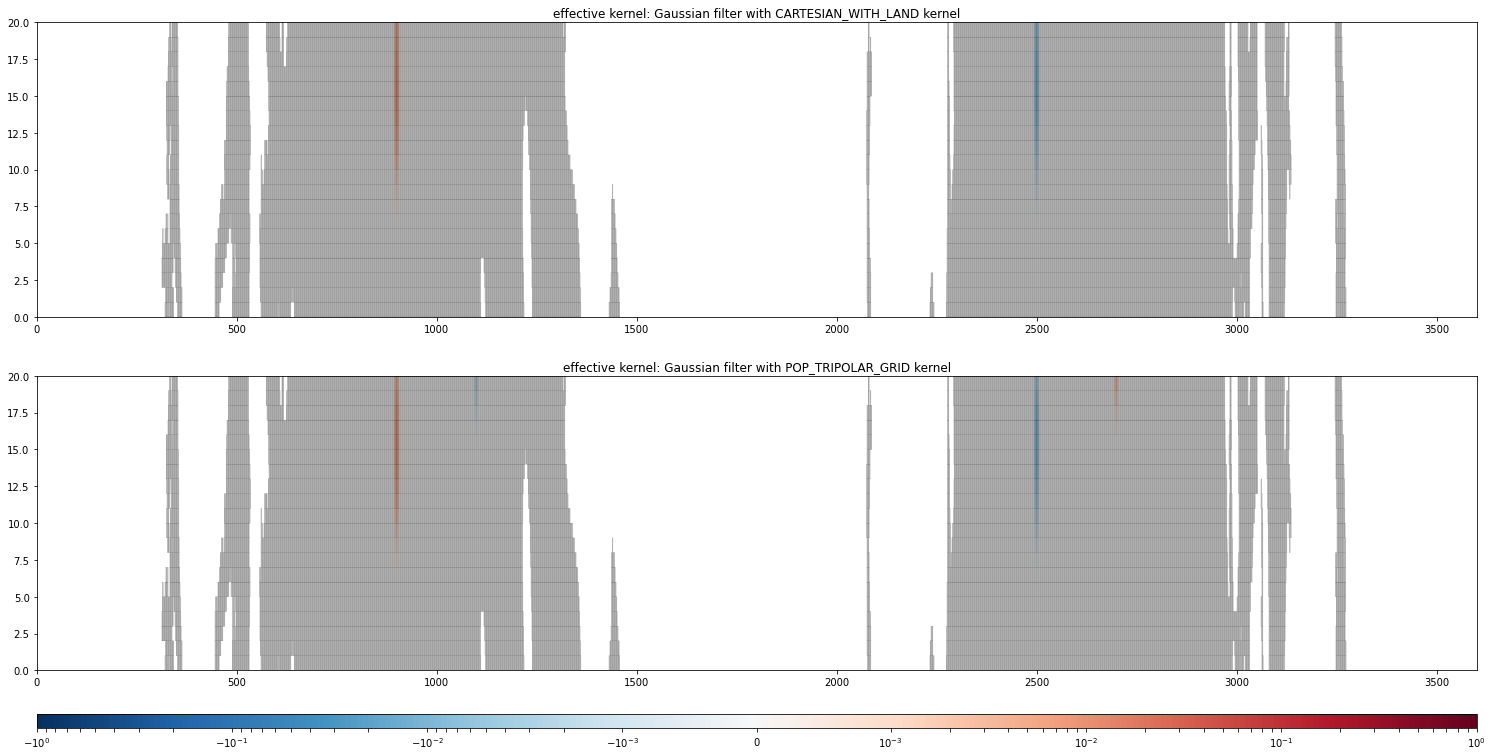

In [12]:
yslice = slice(2380,None)
vmin=-1
vmax=1

fig,axs = plt.subplots(2,1,figsize=(25,10))
        
axs[0].pcolor((delta1_filtered_cartesian_with_land + delta2_filtered_cartesian_with_land).isel(nlat=yslice),
              cmap='RdBu_r',vmin=vmin,vmax=vmax,
              norm=mpl.colors.SymLogNorm(linthresh=0.001),
              edgecolors='k', linewidths=0.1)
p = axs[1].pcolor((delta1_filtered_pop_tripolar_grid + delta2_filtered_pop_tripolar_grid).isel(nlat=yslice),
                    cmap='RdBu_r',vmin=vmin,vmax=vmax,
                    norm=mpl.colors.SymLogNorm(linthresh=0.001),
                    edgecolors='k', linewidths=0.1)

axs[0].set(title='effective kernel: Gaussian filter with CARTESIAN_WITH_LAND kernel')
axs[1].set(title='effective kernel: Gaussian filter with POP_TRIPOLAR_GRID kernel')

# colorbar
fig.subplots_adjust(left=0.1, bottom=-0.02)
cax = fig.add_axes([0.1, -0.1, 0.8, 0.02])
cbar = fig.colorbar(p, cax=cax, orientation='horizontal')

Both panels show the 20 uppermost rows of the POP grid. (C'mon, don't you recognize the Arctic?) The lower panel confirms that the `POP_TRIPOLAR_GRID` allows exchanges across the northern boundary fold, both 
* from left to right (red shading, originating from delta1 deployed with mass=1 in left part of domain); and 
* from right to left (blue shading, originating from delta2 deployed with mass=-1 in right part of domain). 

Note that the `CARTESIAN_WITH_LAND` Laplacian doesn't allow exchanges across the northern boundary fold (as expected).

## Comparing the timing of the 3 filters

We will compare the timing of the 3 filters, by applying them lazily to a Dask array - first on a CPU, then on a GPU.

### CPU

We need to make our input array a Dask array to take advantage of parallel lazy computation:

In [13]:
wet_mask = wet_mask.chunk({'nlat': Ny, 'nlon': Nx})  # 1 chunk
wet_mask

<xarray.DataArray 'KMT' (nlat: 2400, nlon: 3600)>
dask.array<xarray-<this-array>, shape=(2400, 3600), dtype=int64, chunksize=(2400, 3600), chunktype=numpy.ndarray>
Coordinates:
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon

In [14]:
TEMP = ds.TEMP.chunk({'z_t': 31})  # 2 chunks
TEMP

<xarray.DataArray 'TEMP' (time: 1, z_t: 62, nlat: 2400, nlon: 3600)>
dask.array<xarray-<this-array>, shape=(1, 62, 2400, 3600), dtype=float32, chunksize=(1, 31, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 1.238e+04
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

In [15]:
%time TEMP_filtered_cartesian = filter_cartesian.apply(TEMP, dims=['nlat', 'nlon'])

CPU times: user 5.67 ms, sys: 0 ns, total: 5.67 ms
Wall time: 5.41 ms


In [16]:
%time TEMP_filtered_cartesian_with_land = filter_cartesian_with_land.apply(TEMP, dims=['nlat', 'nlon'])

CPU times: user 1.01 s, sys: 334 ms, total: 1.35 s
Wall time: 1.35 s


In [17]:
%time TEMP_filtered_pop_tripolar_grid = filter_pop_tripolar_grid.apply(TEMP, dims=['nlat', 'nlon'])

CPU times: user 1.04 s, sys: 334 ms, total: 1.37 s
Wall time: 1.37 s


In all three cases above, nothing has actually been computed yet. Note that the `POP_TRIPOLAR_GRID` Laplacian is compatible with dask, just as the `CARTESIAN_WITH_LAND` and `CARTESIAN` Laplacians. 

In [18]:
TEMP_filtered_pop_tripolar_grid

<xarray.DataArray (time: 1, z_t: 62, nlat: 2400, nlon: 3600)>
dask.array<transpose, shape=(1, 62, 2400, 3600), dtype=float32, chunksize=(1, 31, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 1.238e+04
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    ULONG    (nlat, nlon) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    ULAT     (nlat, nlon) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    TLONG    (nlat, nlon) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    TLAT     (nlat, nlon) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
Dimensions without coordinates: nlat, nlon

We now trigger computation (e.g., filtering of 62 two-dimensional fields of dimension (2400, 3600)), and compare the times:

In [19]:
%time TEMP_filtered_cartesian_computed = TEMP_filtered_cartesian.compute()

CPU times: user 2min 37s, sys: 1min 8s, total: 3min 46s
Wall time: 1min 56s


In [20]:
%time TEMP_filtered_cartesian_with_land_computed = TEMP_filtered_cartesian_with_land.compute()

CPU times: user 8min 4s, sys: 3min 22s, total: 11min 27s
Wall time: 5min 47s


In [21]:
%time TEMP_filtered_pop_tripolar_grid_computed = TEMP_filtered_pop_tripolar_grid.compute()

CPU times: user 8min 36s, sys: 3min 49s, total: 12min 25s
Wall time: 6min 16s


We make the following observations:
* As expected, the execution time increases from the most simple (`CARTESIAN`) to medium (`CARTESIAN_WITH_LAND`) to most complex (`POP_TRIPOLAR_GRID`) Laplacian implementation. 
* None of these implementation can keep up with Ian's Fortran implementation. He filtered the same data set with a filter comparable to the `POP_TRIPOLAR_GRID` Laplacian, and it took only 0.387s for the uppermost depth level (z_t=0). That would be approximately **24s** for 62 depth levels (assuming sequential composition).

Let's move to a GPU, and see by how much we can accelerate our gcm-filters.

### GPU

Map the NumPy blocks in our Dask arrays to CuPy blocks:

In [22]:
wet_mask.data = wet_mask.data.map_blocks(cp.asarray)
wet_mask

<xarray.DataArray 'KMT' (nlat: 2400, nlon: 3600)>
dask.array<asarray, shape=(2400, 3600), dtype=int64, chunksize=(2400, 3600), chunktype=cupy.ndarray>
Coordinates:
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon

In [23]:
TEMP.data = TEMP.data.map_blocks(cp.asarray)
TEMP

<xarray.DataArray 'TEMP' (time: 1, z_t: 62, nlat: 2400, nlon: 3600)>
dask.array<asarray, shape=(1, 62, 2400, 3600), dtype=float32, chunksize=(1, 31, 2400, 3600), chunktype=cupy.ndarray>
Coordinates:
  * time     (time) float64 1.238e+04
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

Recreate the filters with the cupy wet_mask:

In [24]:
filter_cartesian_with_land = gcm_filters.Filter(
    filter_scale=10,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_steps=20,
    grid_type=gcm_filters.GridType.CARTESIAN_WITH_LAND,
    grid_vars={'wet_mask': wet_mask}
)

filter_pop_tripolar_grid = gcm_filters.Filter(
    filter_scale=10,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_steps=20,
    grid_type=gcm_filters.GridType.POP_TRIPOLAR_GRID,
    grid_vars={'wet_mask': wet_mask}
)

Apply all three filters to the same Dask array on GPU:

In [25]:
%time TEMP_filtered_cartesian = filter_cartesian.apply(TEMP, dims=['nlat', 'nlon'])

CPU times: user 98.6 ms, sys: 3.81 ms, total: 102 ms
Wall time: 105 ms


In [26]:
%time TEMP_filtered_cartesian_with_land = filter_cartesian_with_land.apply(TEMP, dims=['nlat', 'nlon'])

CPU times: user 1.53 s, sys: 360 ms, total: 1.89 s
Wall time: 1.96 s


In [27]:
%time TEMP_filtered_pop_tripolar_grid = filter_pop_tripolar_grid.apply(TEMP, dims=['nlat', 'nlon'])

CPU times: user 1.52 s, sys: 343 ms, total: 1.86 s
Wall time: 1.86 s


In [32]:
TEMP_filtered_pop_tripolar_grid

<xarray.DataArray (time: 1, z_t: 62, nlat: 2400, nlon: 3600)>
dask.array<transpose, shape=(1, 62, 2400, 3600), dtype=float32, chunksize=(1, 31, 2400, 3600), chunktype=cupy.ndarray>
Coordinates:
  * time     (time) float64 1.238e+04
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    ULONG    (nlat, nlon) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    ULAT     (nlat, nlon) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    TLONG    (nlat, nlon) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    TLAT     (nlat, nlon) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
Dimensions without coordinates: nlat, nlon

Trigger computation:

In [29]:
%time TEMP_filtered_cartesian_computed = TEMP_filtered_cartesian.compute()

CPU times: user 7.16 s, sys: 2.47 s, total: 9.62 s
Wall time: 6.05 s


In [30]:
%time TEMP_filtered_cartesian_with_land_computed = TEMP_filtered_cartesian_with_land.compute()

CPU times: user 7.5 s, sys: 2 s, total: 9.5 s
Wall time: 6.12 s


In [31]:
%time TEMP_filtered_pop_tripolar_grid_computed = TEMP_filtered_pop_tripolar_grid.compute()

CPU times: user 5.31 s, sys: 1.49 s, total: 6.8 s
Wall time: 5.23 s


On GPU, all three filters
* have approximately the same execution speed (surprisingly, the most complex one, `POP_TRIPOLAR_GRID`, is even the fastest - but that could be noise)
* are faster than the FORTRAN implementation.

Yay.